# COCO: Coloration

> I want to train a bigger U-net with a bigger dataset and a better data pre-processing pipeline. This notebook is solely for the data-processing pipeline

In [1]:
# |default_exp coco

In [3]:
# |export
import multiprocessing
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.functional as TF
import torchvision.transforms.v2 as T
from datasets import Dataset
from PIL import Image
from tqdm import tqdm

from slowai.learner import DataLoaders
from slowai.tinyimagenet_a import denorm, fill, norm
from slowai.utils import show_images

First, let's download the data.

In [3]:
%%bash
wget http://images.cocodataset.org/zips/train2017.zip -O data/train2017.zip
unzip data/train2017.zip
rm data/train2017.zip

Now, we want to remove all black and white images, because we want to predict the color data. We'll use a simple heuristic to determine if the image is black and white.

In [4]:
# |export
def to_img(im):
    """Convert PIL image to numpy"""
    return np.array(im).astype(np.float32) / 255

In [5]:
# |export
def black_and_white(im, viz=False, thresh=0.01):
    """Infer whether image is black and white by seeing how much
    the original image and a converted black-and-white version
    differ from one another"""
    if isinstance(im, str):
        im = Image.open(im)
    if im.mode == "L":
        return True
    im_color = im.convert("RGB")
    h, w = im_color.size
    im_bw = im_color.convert("L").convert("RGB")
    im_color, im_bw = map(to_img, (im_color, im_bw))
    delta = abs(im_color - im_bw).sum() / (h * w * 3)
    if viz:
        show_images([im_color], titles=[f"Delta: {delta:.4f}"])
    return delta < thresh

In [6]:
fp = "data/train2017"
fps = [str(fi) for fi in Path(fp).glob("**/*.jpg")]

We can see this working as follows:

True

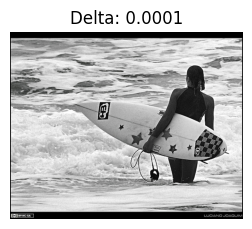

In [7]:
black_and_white(Image.open(fps[0]), viz=True)

False

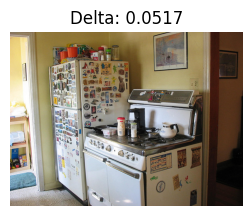

In [8]:
black_and_white(Image.open(fps[1]), viz=True)

In [9]:
fps_color = []
with multiprocessing.Pool() as p:
    iter_ = zip(p.imap(black_and_white, fps), fps)
    for b_w, fp in tqdm(iter_, total=len(fps)):
        if not b_w:
            fps_color.append(fp)

100%|██████████████████████████████████████████████████████████████████████████████████| 118287/118287 [04:46<00:00, 412.95it/s]


In [10]:
fps_color = set(fps_color)
for fp in Path(fp).glob("**/*.jpg"):
    if fp not in fps_color:
        fp.unlink()

In [11]:
# |export
def coco_2017_trn(fps=None, n=None, remove_bw=True):
    """Combine the image preprocessing logic and return a
    huggingface dataset"""
    if fps is None:
        fps = Path(fp).glob("**/*.jpg")
    if n:
        fps = fps[:n]
    ds = Dataset.from_dict({"image_fp": [str(fp) for fp in fps]})

    def open_images(examples):
        imgs = []
        for img_fp in examples["image_fp"]:
            img = Image.open(img_fp)
            imgs.append(img)
        return {"image": imgs}

    ds = ds.map(open_images, batched=True)
    ds = ds.train_test_split(test_size=0.1)
    return ds

In [12]:
%%time
ds = coco_2017_trn(fps_color)

Map:   0%|          | 0/113265 [00:00<?, ? examples/s]

CPU times: user 5.98 s, sys: 1.09 s, total: 7.07 s
Wall time: 9.98 s


In [13]:
ds

DatasetDict({
    train: Dataset({
        features: ['image_fp', 'image'],
        num_rows: 101938
    })
    test: Dataset({
        features: ['image_fp', 'image'],
        num_rows: 11327
    })
})

In [14]:
# |export
def crop_to_box(img: "Image"):
    width, height = img.size
    if width > height:
        new_width = height
        new_height = height
        left = (width - new_width) // 2
        top = 0
        right = left + new_width
        bottom = new_height
    else:
        new_width = width
        new_height = width
        left = 0
        top = (height - new_height) // 2
        right = new_width
        bottom = top + new_height
    img_cropped = img.crop((left, top, right, bottom))
    return img_cropped

In [15]:
# |export
trn_preprocess_super_rez = [
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=(0.35, 1.65), hue=(-0.05, 0.05)),
    T.RandomAffine(scale=(1.0, 1.2), degrees=(0, 20), fill=fill),
    crop_to_box,
    T.Resize((150, 150)),
    T.RandomCrop((128, 128)),
    T.PILToTensor(),
]
tst_preprocess_super_rez = [
    crop_to_box,
    T.Resize((150, 150)),
    T.CenterCrop((128, 128)),
    T.PILToTensor(),
]
blur = T.GaussianBlur((5, 9), (0.1, 5.0))
postprocess_ = T.Compose([T.ConvertImageDtype(torch.float), norm])

In [16]:
# |export
def preprocess_super_rez(examples, pipe, extra_blur=False):
    pre = T.Compose(pipe)
    imgs = []
    for img in examples["image"]:
        img = img.convert("RGB")
        img_hr = pre(img)
        # Note that this resizing discards details but retains the image
        # dimensions, which makes it slightly easier to design the network
        img_lr = TF.resize(img_hr, (64, 64), antialias=True)
        if extra_blur:
            img_lr = blur(img_lr)
        img_lr = TF.resize(img_lr, (128, 128), antialias=False)
        img_hr, img_lr = map(postprocess_, (img_hr, img_lr))
        imgs.append((img_hr, img_lr))
    imgs_hr, imgs_lr = map(torch.stack, zip(*imgs))
    return {"image_high_rez": imgs_hr, "image_low_rez": imgs_lr}

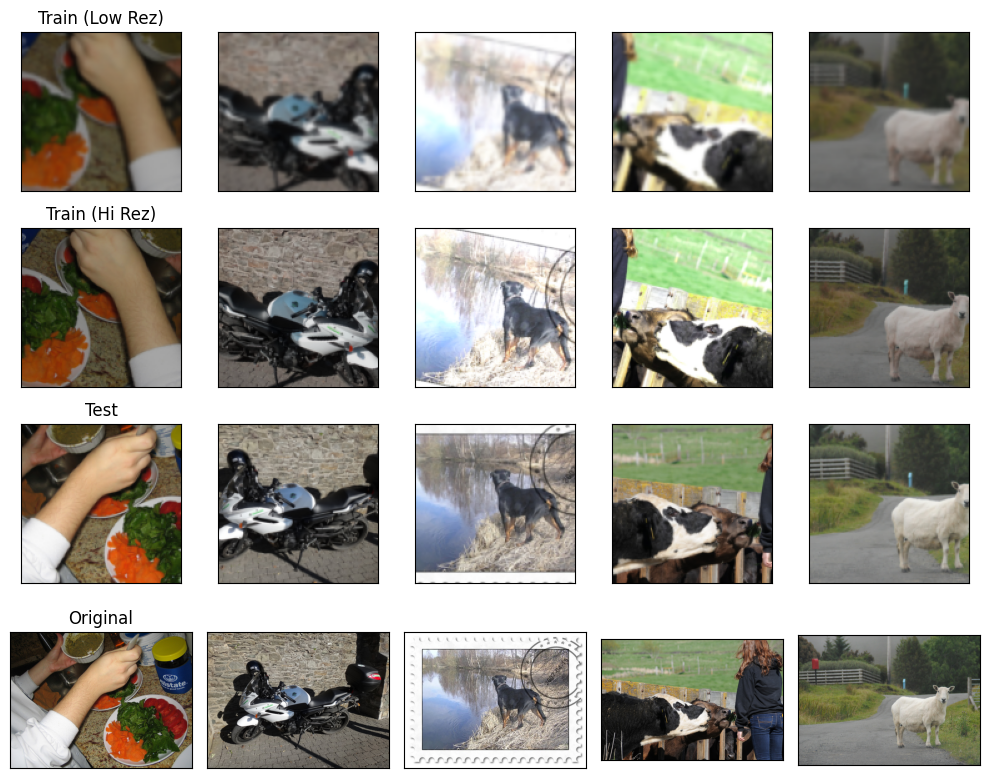

In [17]:
rows = ds["train"][:6]
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
trn = preprocess_super_rez(rows, pipe=trn_preprocess_super_rez)
tst = preprocess_super_rez(rows, pipe=tst_preprocess_super_rez)
for im_trn_hi, im_trn_lo, im_test, im_org, ax_col in zip(
    trn["image_high_rez"],
    trn["image_low_rez"],
    tst["image_high_rez"],
    rows["image"],
    axes.T,
):
    for ax, im in zip(ax_col, (im_trn_lo, im_trn_hi, im_test)):
        ax.imshow(denorm(im).permute(1, 2, 0))
    ax_col[3].imshow(im_org)
axes[0, 0].set(title="Train (Low Rez)")
axes[1, 0].set(title="Train (Hi Rez)")
axes[2, 0].set(title="Test")
axes[3, 0].set(title="Original")
fig.tight_layout()

In [27]:
# |export
def get_coco_dataset(
    fac,
    trn,
    tst,
    fp="data/train2017",
    bs=512,
    n=None,
    columns=["image_low_rez", "image_high_rez"],
):
    fps = list(Path(fp).glob("**/*.jpg"))
    dsd = coco_2017_trn(fps, n=n)
    dsd["train"].set_transform(partial(fac, pipe=trn))
    dsd["train"] = dsd["train"].shuffle()
    dsd["test"] = (
        dsd["test"]
        .map(
            partial(fac, pipe=tst),
            batched=True,
            # Unused, no need to collate and waste time/compute
            remove_columns=["image"],
        )
        .with_format("torch")
    )

    return DataLoaders.from_dsd(dsd, bs=bs).listify(columns=columns)

In [28]:
# |export
get_coco_dataset_super_rez = partial(
    get_coco_dataset,
    preprocess_super_rez,
    trn_preprocess_super_rez,
    tst_preprocess_super_rez,
)

In [29]:
%%time
dls = get_coco_dataset_super_rez(n=100)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

CPU times: user 842 ms, sys: 188 ms, total: 1.03 s
Wall time: 858 ms


We also want to do colorization

In [30]:
# |export
grayscale = T.Grayscale(num_output_channels=3)

In [31]:
# |export
def preprocess_colorization(examples, pipe):
    pre = T.Compose(pipe)
    imgs = []
    for img in examples["image"]:
        img_color = pre(img.convert("RGB"))
        img_bw = grayscale(img_color)
        img_color, img_bw = map(postprocess_, (img_color, img_bw))
        imgs.append((img_color, img_bw))
    imgs_color, imgs_bw = map(torch.stack, zip(*imgs))
    return {"color": imgs_color, "bw": imgs_bw}

In [32]:
# |export
get_coco_dataset_colorization = partial(
    get_coco_dataset,
    preprocess_colorization,
    trn_preprocess_super_rez,
    tst_preprocess_super_rez,
    columns=["bw", "color"],
)

In [33]:
%%time
dls = get_coco_dataset_colorization(n=100)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

CPU times: user 959 ms, sys: 162 ms, total: 1.12 s
Wall time: 897 ms


In [34]:
xb, yb = dls.peek()

In [35]:
denorm(xb).max()

tensor(0.9961)

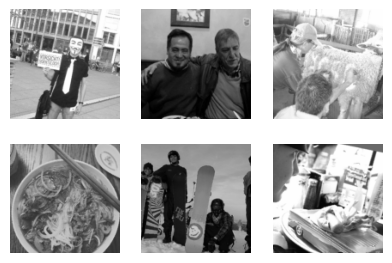

In [36]:
show_images(denorm(xb[:6, ...]), imsize=(1.6))

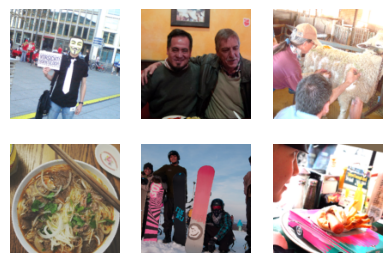

In [37]:
show_images(denorm(yb[:6, ...]), imsize=(1.6))

In [38]:
#| hide
import nbdev

nbdev.nbdev_export()